# P3-Anticipez les besoins en consommation électrique de bâtiments : Modèles prédictifs pour l'émission totale de gaz à effet de serre

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from math import log
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

## Importation des données 

In [2]:
data = pd.read_csv("data_nett.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         3231 non-null   float64
 1   CouncilDistrictCode              3231 non-null   int64  
 2   YearBuilt                        3231 non-null   float64
 3   NumberofBuildings                3231 non-null   float64
 4   NumberofFloors                   3231 non-null   float64
 5   PropertyGFATotal                 3231 non-null   float64
 6   PropertyGFAParking               3231 non-null   float64
 7   PropertyGFABuilding(s)           3231 non-null   float64
 8   LargestPropertyUseTypeGFA        3231 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 11  ENERGYSTARScore                  3231 non-null   float64
 12  SiteEnergyUse(kBtu) 

In [4]:
data.isna().mean()

DataYear                           0.000000
CouncilDistrictCode                0.000000
YearBuilt                          0.000000
NumberofBuildings                  0.000000
NumberofFloors                     0.000000
PropertyGFATotal                   0.000000
PropertyGFAParking                 0.000000
PropertyGFABuilding(s)             0.000000
LargestPropertyUseTypeGFA          0.000000
SecondLargestPropertyUseTypeGFA    0.000000
ThirdLargestPropertyUseTypeGFA     0.000000
ENERGYSTARScore                    0.000000
SiteEnergyUse(kBtu)                0.000000
TotalGHGEmissions                  0.000000
ZipCode                            0.000000
Latitude                           0.000000
Longitude                          0.000000
BuildingType                       0.000000
PrimaryPropertyType                0.000000
Neighborhood                       0.000000
LargestPropertyUseType             0.021975
SecondLargestPropertyUseType       0.493036
ThirdLargestPropertyUseType     

In [5]:
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].astype(str)
data['SecondLargestPropertyUseType'] = data['SecondLargestPropertyUseType'].astype(str)
data['ThirdLargestPropertyUseType'] = data['ThirdLargestPropertyUseType'].astype(str)

In [6]:
data.isna().mean()

DataYear                           0.0
CouncilDistrictCode                0.0
YearBuilt                          0.0
NumberofBuildings                  0.0
NumberofFloors                     0.0
PropertyGFATotal                   0.0
PropertyGFAParking                 0.0
PropertyGFABuilding(s)             0.0
LargestPropertyUseTypeGFA          0.0
SecondLargestPropertyUseTypeGFA    0.0
ThirdLargestPropertyUseTypeGFA     0.0
ENERGYSTARScore                    0.0
SiteEnergyUse(kBtu)                0.0
TotalGHGEmissions                  0.0
ZipCode                            0.0
Latitude                           0.0
Longitude                          0.0
BuildingType                       0.0
PrimaryPropertyType                0.0
Neighborhood                       0.0
LargestPropertyUseType             0.0
SecondLargestPropertyUseType       0.0
ThirdLargestPropertyUseType        0.0
dtype: float64

In [7]:
print(data.shape)
data = data.drop(['SiteEnergyUse(kBtu)'], axis=1)
print(data.shape)

(3231, 23)
(3231, 22)


<AxesSubplot:>

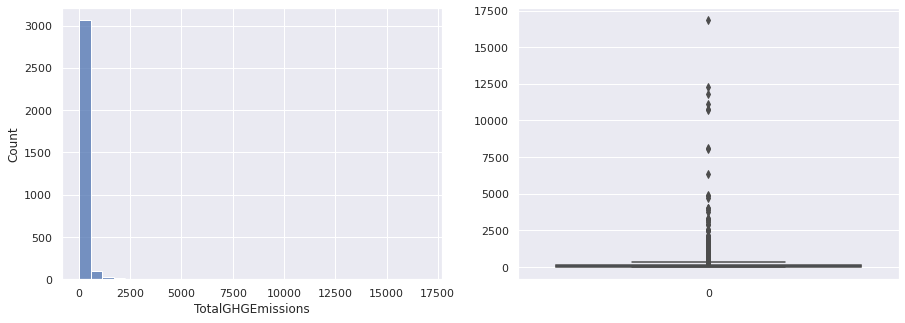

In [8]:
#Pour rappel : Histogramme de distribution et boxplot'

var = 'TotalGHGEmissions'

sns.set(rc = {'figure.figsize':(15,5)})
fig, (ax1, ax2) = plt.subplots(1,2)
sns.histplot(data, x=var, bins=30, ax=ax1)
sns.boxplot(data = data[var], ax=ax2)

In [9]:
data['TotalGHGEmissions'].describe()

count     3231.000000
mean       178.840405
std        673.324402
min          0.000000
25%         20.070000
50%         49.280000
75%        139.225000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64

## Data Preprocessing 

In [10]:
#Définition des variables X et de la target y

X = data.drop(['TotalGHGEmissions'], axis=1)
y = data['TotalGHGEmissions']

In [11]:
print(X.shape)
print(y.shape)

(3231, 21)
(3231,)


In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         3231 non-null   float64
 1   CouncilDistrictCode              3231 non-null   int64  
 2   YearBuilt                        3231 non-null   float64
 3   NumberofBuildings                3231 non-null   float64
 4   NumberofFloors                   3231 non-null   float64
 5   PropertyGFATotal                 3231 non-null   float64
 6   PropertyGFAParking               3231 non-null   float64
 7   PropertyGFABuilding(s)           3231 non-null   float64
 8   LargestPropertyUseTypeGFA        3231 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 11  ENERGYSTARScore                  3231 non-null   float64
 12  ZipCode             

In [13]:
#Encodage des variables qualitatives

encoder = LabelEncoder()

X['BuildingType'] = encoder.fit_transform(X['BuildingType'])
X['PrimaryPropertyType'] = encoder.fit_transform(X['PrimaryPropertyType'])
X['Neighborhood'] = encoder.fit_transform(X['Neighborhood'])
X['LargestPropertyUseType'] = encoder.fit_transform(X['LargestPropertyUseType'])
X['SecondLargestPropertyUseType'] = encoder.fit_transform(X['SecondLargestPropertyUseType'])
X['ThirdLargestPropertyUseType'] = encoder.fit_transform(X['ThirdLargestPropertyUseType'])

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         3231 non-null   float64
 1   CouncilDistrictCode              3231 non-null   int64  
 2   YearBuilt                        3231 non-null   float64
 3   NumberofBuildings                3231 non-null   float64
 4   NumberofFloors                   3231 non-null   float64
 5   PropertyGFATotal                 3231 non-null   float64
 6   PropertyGFAParking               3231 non-null   float64
 7   PropertyGFABuilding(s)           3231 non-null   float64
 8   LargestPropertyUseTypeGFA        3231 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 11  ENERGYSTARScore                  3231 non-null   float64
 12  ZipCode             

In [15]:
#Constitution des jeux de données test et train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2584, 21)
(2584,)
(647, 21)
(647,)


## Constructions des modèles avec optimisation des hyperparamètres

### Ridge Regression

#### Mise en place du modèle 

In [16]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', Ridge())    #Application du modèle = Regression Ridge
]
ridge_pipe = Pipeline(steps) #Création du pipeline

In [17]:
#Entraînement du modèle sur les données d'apprentissage

ridge_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge())])

#### Optimisation de l'hyperparamètre alpha

In [20]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(100, 1500, 10)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [21]:
#Meilleure valeur pour alpha
grid_ridge.best_params_

{'model__alpha': 570}

In [22]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(550, 590, 1)} #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge = GridSearchCV(estimator = ridge_pipe, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_root_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge = grid_ridge.fit(X_train, y_train)

In [23]:
#Meilleure valeur pour alpha
alpha_opt = grid_ridge.best_params_['model__alpha']
print(alpha_opt)

572


In [24]:
#Valeur de score la plus basse
score_ridge = grid_ridge.best_score_
score_ridge = round(score_ridge)
print(score_ridge)

-416


In [25]:
#Meilleur modèle
grid_ridge.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge(alpha=572))])

#### Evaluation de la cross validation

In [26]:
#Relance de la Grid Search en cross validation avec l'alpha optimal et le R2 score

parameters = {'model__alpha': [alpha_opt] }
 
grid_ridge_opt = GridSearchCV(estimator = ridge_pipe,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_opt = grid_ridge_opt.fit(X_train, y_train)

In [27]:
#Valeur du R2
R2_ridge = round(grid_ridge_opt.best_score_,3)
print(R2_ridge)

0.404


### Modèle : Random Forest

#### Mise en place du modèle

In [28]:
##Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', RandomForestRegressor(random_state = 0))    #Application du modèle = random_forest
]
random_pipe = Pipeline(steps) #Création du pipeline

In [29]:
#Entraînement du modèle sur les données d'apprentissage

random_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model', RandomForestRegressor(random_state=0))])

#### Optimisation des hyperparamètres

In [30]:
parameters = {
    'model__n_estimators' : np.arange(1,100,10),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(1,20,2)
    }

In [31]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [32]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4000 fits failed out of a total of 36000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])},
             scoring='neg_root_mean_squared_error')

In [33]:
grid_random.best_params_

{'model__max_depth': 15,
 'model__max_features': 0.2,
 'model__min_samples_split': 2,
 'model__n_estimators': 31}

In [34]:
grid_random.best_score_

-303.9504199693328

In [ ]:
je relance en affinant les espaces de recherche.

In [35]:
parameters = {
    'model__n_estimators' : np.arange(20,40,1),
    'model__max_features' : np.arange(0.1,0.9, 0.1),
    'model__min_samples_split' : np.arange(1,10,1),
    'model__max_depth' : np.arange(10,20,1)
    }

In [36]:
grid_random = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [37]:
grid_random.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8000 fits failed out of a total of 72000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'model__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model__n_estimators': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])},
             scoring='neg_root_mean_squared_error')

In [38]:
grid_random.best_params_

{'model__max_depth': 15,
 'model__max_features': 0.2,
 'model__min_samples_split': 2,
 'model__n_estimators': 30}

In [39]:
score_random = grid_random.best_score_
score_random = round(score_random)
print(score_random)

-303


In [40]:
max_depth_opt = grid_random.best_params_['model__max_depth']
print(max_depth_opt)

15


In [41]:
max_features_opt = grid_random.best_params_['model__max_features']
print(max_features_opt)

0.2


In [42]:
min_samples_split_opt = grid_random.best_params_['model__min_samples_split']
print(min_samples_split_opt)

2


In [43]:
n_estimators_opt = grid_random.best_params_['model__n_estimators']
print(n_estimators_opt)

30


In [44]:
grid_random.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model',
                 RandomForestRegressor(max_depth=15, max_features=0.2,
                                       n_estimators=30, random_state=0))])

Text(0.5, 0, 'Relative Importance')

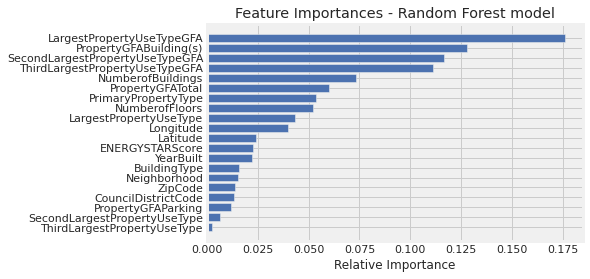

In [46]:
importances = grid_random.best_estimator_['model'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Random Forest model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [47]:
parameters_opt = {
    'model__n_estimators' : [n_estimators_opt],
    'model__max_features' : [max_features_opt],
    'model__min_samples_split' : [min_samples_split_opt],
    'model__max_depth' : [max_depth_opt]
    }

In [48]:
grid_random_opt = GridSearchCV(estimator = random_pipe,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [49]:
grid_random_opt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [15], 'model__max_features': [0.2],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [30]},
             scoring='r2')

In [50]:
R2_random = round(grid_random_opt.best_score_,3)
print(R2_random)

0.694


### Modèle : Gradient Boosting

#### Mise en place du modèle

In [51]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model_boost', GradientBoostingRegressor(random_state = 0))    #Application du modèle = random_forest
]
boost_pipe = Pipeline(steps) #Création du pipeline

In [52]:
#Entraînement du modèle sur les données d'apprentissage

boost_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost', GradientBoostingRegressor(random_state=0))])

In [56]:
parameters = {
    'model_boost__n_estimators' : np.arange(1,50,10),
    'model_boost__learning_rate' : np.arange(0.1,1, 0.1),
    'model_boost__min_samples_split' : np.arange(1,50,5),
    'model_boost__max_depth' : np.arange(1,20,2)
}

In [57]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [58]:
grid_boost.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2250 fits failed out of a total of 22500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2250 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'model_boost__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model_boost__min_samples_split': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'model_boost__n_estimators': array([ 1, 11, 21, 31, 41])},
             scoring='neg_root_mean_squared_error')

In [59]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 21,
 'model_boost__n_estimators': 41}

In [60]:
grid_boost.best_score_

-258.5943796662298

In [61]:
parameters = {
    'model_boost__n_estimators' : np.arange(40,100,10),
    'model_boost__learning_rate' : np.arange(0.1,1, 0.1),
    'model_boost__min_samples_split' : np.arange(1,50,5),
    'model_boost__max_depth' : np.arange(1,20,2)
}

In [62]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [63]:
grid_boost.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2700 fits failed out of a total of 27000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'model_boost__max_depth': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                         'model_boost__min_samples_split': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'model_boost__n_estimators': array([40, 50, 60, 70, 80, 90])},
             scoring='neg_root_mean_squared_error')

In [64]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 21,
 'model_boost__n_estimators': 90}

In [65]:
grid_boost.best_score_

-245.94192858244418

In [73]:
parameters = {
    'model_boost__n_estimators' : np.arange(100,600,50),
    'model_boost__learning_rate' : np.arange(0.1,0.5, 0.1),
    'model_boost__min_samples_split' : np.arange(1,30,5),
    'model_boost__max_depth' : np.arange(1,5,1)
}

In [74]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [75]:
grid_boost.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
800 fits failed out of a total of 4800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
800 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensemble

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                         'model_boost__max_depth': array([1, 2, 3, 4]),
                         'model_boost__min_samples_split': array([ 1,  6, 11, 16, 21, 26]),
                         'model_boost__n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550])},
             scoring='neg_root_mean_squared_error')

In [76]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 21,
 'model_boost__n_estimators': 550}

In [77]:
grid_boost.best_score_

-239.61281726337566

In [78]:
parameters = {
    'model_boost__n_estimators' : np.arange(550,1200,50),
    'model_boost__learning_rate' : np.arange(0.1,0.5, 0.1),
    'model_boost__min_samples_split' : np.arange(1,30,5),
    'model_boost__max_depth' : np.arange(1,5,1)
}

In [79]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [80]:
grid_boost.fit(X_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1040 fits failed out of a total of 6240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1040 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensemb

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1, 0.2, 0.3, 0.4]),
                         'model_boost__max_depth': array([1, 2, 3, 4]),
                         'model_boost__min_samples_split': array([ 1,  6, 11, 16, 21, 26]),
                         'model_boost__n_estimators': array([ 550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150])},
             scoring='neg_root_mean_squared_error')

In [81]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.30000000000000004,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 21,
 'model_boost__n_estimators': 800}

In [82]:
grid_boost.best_score_

-239.33319542403032

In [83]:
parameters = {
    'model_boost__n_estimators' : np.arange(700,900,10),
    'model_boost__learning_rate' : np.arange(0.1,0.5, 0.05),
    'model_boost__min_samples_split' : np.arange(15,25,1),
    'model_boost__max_depth' : np.arange(1,5,1)
}

In [84]:
grid_boost = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [85]:
grid_boost.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'model_boost__max_depth': array([1, 2, 3, 4]),
                         'model_boost__min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                         'model_boost__n_estimators': array([700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820,
       830, 840, 850, 860, 870, 880, 890])},
             scoring='neg_root_mean_squared_error')

In [86]:
grid_boost.best_params_

{'model_boost__learning_rate': 0.25000000000000006,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 23,
 'model_boost__n_estimators': 880}

In [87]:
grid_boost.best_score_

-234.75265562120512

In [102]:
score_boost = grid_boost.best_score_
score_boost = round(score_boost)
print(score_boost)

-235


In [89]:
learning_rate_boost_opt = round(grid_boost.best_params_['model_boost__learning_rate'],2)
print(learning_rate_boost_opt)

0.25


In [90]:
max_depth_boost_opt = grid_boost.best_params_['model_boost__max_depth']
print(max_depth_boost_opt)

3


In [91]:
min_samples_split_boost_opt = grid_boost.best_params_['model_boost__min_samples_split']
print(min_samples_split_boost_opt)

23


In [92]:
n_estimators_boost_opt = grid_boost.best_params_['model_boost__n_estimators']
print(n_estimators_boost_opt)

880


In [93]:
grid_boost.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost',
                 GradientBoostingRegressor(learning_rate=0.25000000000000006,
                                           min_samples_split=23,
                                           n_estimators=880, random_state=0))])

Text(0.5, 0, 'Relative Importance')

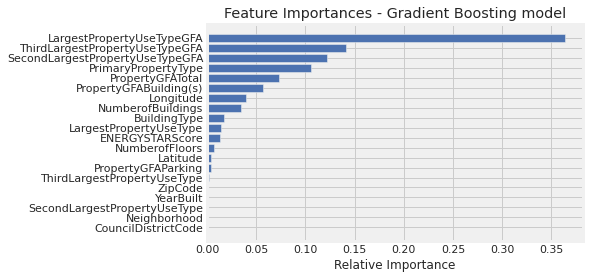

In [94]:
importances = grid_boost.best_estimator_['model_boost'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Gradient Boosting model')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [96]:
parameters_opt = {
    'model_boost__n_estimators' : [n_estimators_boost_opt],
    'model_boost__learning_rate' : [learning_rate_boost_opt],
    'model_boost__min_samples_split' : [min_samples_split_boost_opt],
    'model_boost__max_depth' : [max_depth_boost_opt]
}

In [97]:
grid_boost_opt = GridSearchCV(estimator = boost_pipe,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [98]:
grid_boost_opt.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': [0.25],
                         'model_boost__max_depth': [3],
                         'model_boost__min_samples_split': [23],
                         'model_boost__n_estimators': [880]},
             scoring='r2')

In [99]:
R2_boost = round(grid_boost_opt.best_score_,3)
print(R2_boost)

0.787


## Choix du meilleur modèle

In [103]:
results = pd.DataFrame({
    'Ridge_regression' : [grid_ridge.best_estimator_, score_ridge, R2_ridge],
    'Random Forest' : [grid_random.best_estimator_, score_random, R2_random],
    'Gradient Boosting' : [grid_boost.best_estimator_, score_boost, R2_boost]
}, index = ['Best estimator', 'Grid search error score', 'R2 score'])

In [104]:
results

,Ridge_regression,Random Forest,Gradient Boosting
Best estimator,"(StandardScaler(), Ridge(alpha=572))","(StandardScaler(), (DecisionTreeRegressor(max_...","(StandardScaler(), ([DecisionTreeRegressor(cri..."
Grid search error score,-416,-303,-235
R2 score,0.404,0.694,0.787


## Prédiction

### Baseline

In [79]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('dummy_regr', DummyRegressor(strategy="mean"))    #Application du modèle
]
dummy_regr_pipe = Pipeline(steps) #Création du pipeline

In [80]:
dummy_regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('dummy_regr', DummyRegressor())])

In [84]:
y_pred_dummy = dummy_regr_pipe.predict(X_test)

In [85]:
print('RMSE_dummy : ', np.sqrt(mean_squared_error(y_test,y_pred_dummy)))
print('R2_Score_dummy : ', r2_score(y_test,y_pred_dummy))

RMSE_dummy :  913.7825121742885
R2_Score_dummy :  -0.0003238239700298351


### Meilleur modèle

In [105]:
#Prédictions à partir des données tests

y_pred_boost = grid_boost.best_estimator_.predict(X_test)

RMSE_grid :  519.1551770816351
R2_Score_grid :  0.6771139322913269


/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Density'>

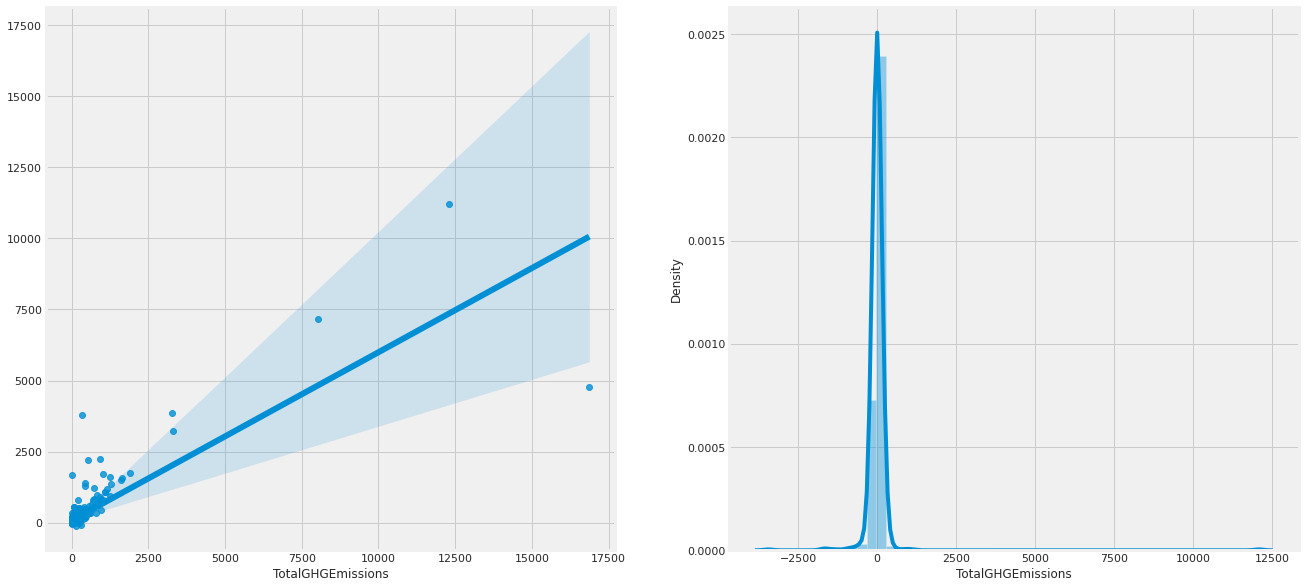

In [106]:
#Evaluation de la prédiction par gradient Boosting

print('RMSE_grid : ', np.sqrt(mean_squared_error(y_test,y_pred_boost)))
print('R2_Score_grid : ', r2_score(y_test,y_pred_boost))
f, axes = plt.subplots(1,2,figsize=(20,10))
sns.regplot(x = y_test, y = y_pred_boost,ax = axes[0])
sns.distplot((y_test-y_pred_boost),ax = axes[1])

# Impact de l'ENERGY STAR SCORE

## Data pre-processing

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         3231 non-null   float64
 1   CouncilDistrictCode              3231 non-null   int64  
 2   YearBuilt                        3231 non-null   float64
 3   NumberofBuildings                3231 non-null   float64
 4   NumberofFloors                   3231 non-null   float64
 5   PropertyGFATotal                 3231 non-null   float64
 6   PropertyGFAParking               3231 non-null   float64
 7   PropertyGFABuilding(s)           3231 non-null   float64
 8   LargestPropertyUseTypeGFA        3231 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 11  ENERGYSTARScore                  3231 non-null   float64
 12  ZipCode             

In [17]:
print(X.shape)
X_STAR = X.drop(['ENERGYSTARScore'], axis=1)
print(X_STAR.shape)

(3231, 21)
(3231, 20)


In [18]:
X_STAR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 20 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DataYear                         3231 non-null   float64
 1   CouncilDistrictCode              3231 non-null   int64  
 2   YearBuilt                        3231 non-null   float64
 3   NumberofBuildings                3231 non-null   float64
 4   NumberofFloors                   3231 non-null   float64
 5   PropertyGFATotal                 3231 non-null   float64
 6   PropertyGFAParking               3231 non-null   float64
 7   PropertyGFABuilding(s)           3231 non-null   float64
 8   LargestPropertyUseTypeGFA        3231 non-null   float64
 9   SecondLargestPropertyUseTypeGFA  3231 non-null   float64
 10  ThirdLargestPropertyUseTypeGFA   3231 non-null   float64
 11  ZipCode                          3231 non-null   int64  
 12  Latitude            

In [19]:
#Constitution des jeux de données test et train

X_STAR_train, X_STAR_test, y_train, y_test = train_test_split(X_STAR, y, test_size = 0.2, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2584, 21)
(2584,)
(647, 21)
(647,)


## Construction des modèles avec optimisation des hyperparamètres

### Ridge Regression

#### Mise en place du modèle 

In [40]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model', Ridge())    #Application du modèle = Regression Ridge
]
ridge_pipe_STAR = Pipeline(steps) #Création du pipeline

In [41]:
#Entraînement du modèle sur les données d'apprentissage

ridge_pipe_STAR.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge())])

#### Optimisation de l'hyperparamètre alpha

In [42]:
#Optimisation de l'hyperparamètre alpha par Grid search sur les données d'apprentissage

parameters = {'model__alpha': np.arange(0, 550, 1) } #Je définie l'étendue de la grille pour les valeurs d'alpha
 
grid_ridge_STAR = GridSearchCV(estimator = ridge_pipe_STAR, #Optimisation automatique des paramètres selon la grille définie
                           param_grid = parameters,
                           scoring = 'neg_mean_squared_error',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_STAR = grid_ridge_STAR.fit(X_STAR_train, y_train)

In [43]:
#Meilleure valeur pour alpha
alpha_opt_STAR = grid_ridge_STAR.best_params_['model__alpha']
print(alpha_opt_STAR)

203


In [44]:
#Valeur de score la plus basse
score_ridge_STAR = grid_ridge_STAR.best_score_
score_ridge_STAR = round(score_ridge_STAR)
print(score_ridge_STAR)

-200813


In [45]:
#Meilleur modèle
grid_ridge_STAR.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()), ('model', Ridge(alpha=203))])

#### Evaluation de la cross validation

In [46]:
#Relance de la Grid Search en cross validation avec l'alpha optimal et le R2 score

parameters = {'model__alpha': [alpha_opt_STAR] }
 
grid_ridge_STAR_opt = GridSearchCV(estimator = ridge_pipe_STAR,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = KFold(5, random_state=0, shuffle=True),
                           n_jobs = -1)
grid_ridge_STAR_opt = grid_ridge_STAR_opt.fit(X_STAR_train, y_train)

In [47]:
#Valeur du R2
R2_ridge_STAR = round(grid_ridge_STAR_opt.best_score_,3)
print(R2_ridge_STAR)

0.369


### Modèle : Random Forest

#### Mise en place du modèle

In [48]:
##Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model_random', RandomForestRegressor(random_state = 0))    #Application du modèle = random_forest
]
random_pipe_STAR = Pipeline(steps) #Création du pipeline

In [49]:
#Entraînement du modèle sur les données d'apprentissage

random_pipe_STAR.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_random', RandomForestRegressor(random_state=0))])

#### Optimisation des hyperparamètres

In [50]:
parameters = {
    'model_random__n_estimators' : np.arange(20,40,1),
    'model_random__max_features' : np.arange(0.1,0.9, 0.1),
    'model_random__min_samples_split' : np.arange(1,10,1),
    'model_random__max_depth' : np.arange(10,20,1)
    }

In [51]:
grid_random_STAR = GridSearchCV(estimator = random_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [52]:
grid_random_STAR.fit(X_STAR_train,y_train)

/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8000 fits failed out of a total of 72000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8000 fits failed with the following error:
Traceback (most recent call last):
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/sklearn/ensem

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_random',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_random__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                         'model_random__max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                         'model_random__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model_random__n_estimators': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39])},
             scoring='neg_root_mean_squared_error')

In [54]:
grid_random_STAR.best_params_

{'model_random__max_depth': 12,
 'model_random__max_features': 0.1,
 'model_random__min_samples_split': 2,
 'model_random__n_estimators': 32}

In [55]:
grid_random_STAR.best_score_

-296.14527182881636

In [56]:
score_random_STAR = grid_random_STAR.best_score_
score_random_STAR = round(score_random_STAR)
print(score_random_STAR)

-296


In [57]:
max_depth_STAR_opt = grid_random_STAR.best_params_['model_random__max_depth']
print(max_depth_STAR_opt)

12


In [58]:
max_features_STAR_opt = round(grid_random_STAR.best_params_['model_random__max_features'],2)
print(max_features_STAR_opt)

0.1


In [59]:
min_samples_split_STAR_opt = grid_random_STAR.best_params_['model_random__min_samples_split']
print(min_samples_split_STAR_opt)

2


In [60]:
n_estimators_STAR_opt = grid_random_STAR.best_params_['model_random__n_estimators']
print(n_estimators_STAR_opt)

32


In [61]:
grid_random_STAR.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_random',
                 RandomForestRegressor(max_depth=12, max_features=0.1,
                                       n_estimators=32, random_state=0))])

Text(0.5, 0, 'Relative Importance')

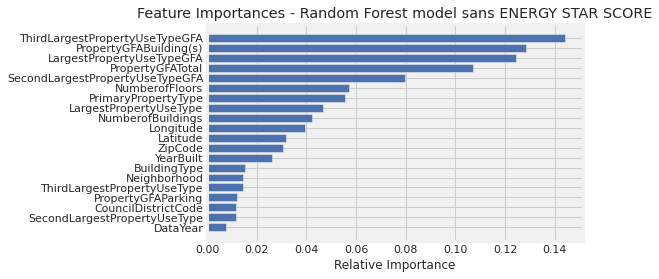

In [62]:
importances = grid_random_STAR.best_estimator_['model_random'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X_STAR.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Random Forest model sans ENERGY STAR SCORE')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [63]:
parameters_opt = {
    'model_random__n_estimators' : [n_estimators_STAR_opt],
    'model_random__max_features' : [max_features_STAR_opt],
    'model_random__min_samples_split' : [min_samples_split_STAR_opt],
    'model_random__max_depth' : [max_depth_STAR_opt]
    }

In [64]:
grid_random_STAR_opt = GridSearchCV(estimator = random_pipe_STAR,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [65]:
grid_random_STAR_opt.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_random',
                                        RandomForestRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_random__max_depth': [12],
                         'model_random__max_features': [0.1],
                         'model_random__min_samples_split': [2],
                         'model_random__n_estimators': [32]},
             scoring='r2')

In [67]:
R2_random_STAR = round(grid_random_STAR_opt.best_score_,3)
print(R2_random_STAR)

0.707


### Modèle : Gradient Boosting

#### Mise en place du modèle

In [21]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('model_boost', GradientBoostingRegressor(random_state = 0))    #Application du modèle = random_forest
]
boost_pipe_STAR = Pipeline(steps) #Création du pipeline

In [22]:
#Entraînement du modèle sur les données d'apprentissage

boost_pipe_STAR.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost', GradientBoostingRegressor(random_state=0))])

In [234]:
parameters = {
    'model_boost__n_estimators' : np.arange(700,900,10),
    'model_boost__learning_rate' : np.arange(0.1,0.5, 0.05),
    'model_boost__min_samples_split' : np.arange(15,25,1),
    'model_boost__max_depth' : np.arange(1,5,1)
}

In [235]:
grid_boost_STAR = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [236]:
grid_boost_STAR.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45]),
                         'model_boost__max_depth': array([1, 2, 3, 4]),
                         'model_boost__min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                         'model_boost__n_estimators': array([700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820,
       830, 840, 850, 860, 870, 880, 890])},
             scoring='neg_root_mean_squared_error')

In [237]:
grid_boost_STAR.best_params_

{'model_boost__learning_rate': 0.1,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 17,
 'model_boost__n_estimators': 890}

In [238]:
score_boost_STAR = grid_boost_STAR.best_score_
score_boost_STAR = round(score_boost_STAR)
print(score_boost_STAR)

-241


In [247]:
parameters = {
    'model_boost__n_estimators' : np.arange(880,1100,10),
    'model_boost__learning_rate' : np.arange(0.01,0.2, 0.05),
    'model_boost__min_samples_split' : np.arange(15,25,1),
    'model_boost__max_depth' : np.arange(1,5,1)
}

In [248]:
grid_boost_STAR = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [249]:
grid_boost_STAR.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.01, 0.06, 0.11, 0.16]),
                         'model_boost__max_depth': array([1, 2, 3, 4]),
                         'model_boost__min_samples_split': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24]),
                         'model_boost__n_estimators': array([ 880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090])},
             scoring='neg_root_mean_squared_error')

In [250]:
grid_boost_STAR.best_params_

{'model_boost__learning_rate': 0.060000000000000005,
 'model_boost__max_depth': 4,
 'model_boost__min_samples_split': 17,
 'model_boost__n_estimators': 1090}

In [251]:
score_boost_STAR = grid_boost_STAR.best_score_
score_boost_STAR = round(score_boost_STAR)
print(score_boost_STAR)

-246


In [252]:
parameters = {
    'model_boost__n_estimators' : np.arange(1050,1300,10),
    'model_boost__learning_rate' : np.arange(0.01,0.2, 0.05),
    'model_boost__min_samples_split' : np.arange(15,20,1),
    'model_boost__max_depth' : np.arange(1,10,1)
}

In [253]:
grid_boost_STAR = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [254]:
grid_boost_STAR.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.01, 0.06, 0.11, 0.16]),
                         'model_boost__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model_boost__min_samples_split': array([15, 16, 17, 18, 19]),
                         'model_boost__n_estimators': array([1050, 1060, 1070, 1080, 1090, 1100, 1110, 1120, 1130, 1140, 1150,
       1160, 1170, 1180, 1190, 1200, 1210, 1220, 1230, 1240, 1250, 1260,
       1270, 1280, 1290])},
             scoring='neg_root_mean_squared_error')

In [255]:
grid_boost_STAR.best_params_

{'model_boost__learning_rate': 0.060000000000000005,
 'model_boost__max_depth': 4,
 'model_boost__min_samples_split': 17,
 'model_boost__n_estimators': 1290}

In [256]:
score_boost_STAR = grid_boost_STAR.best_score_
score_boost_STAR = round(score_boost_STAR)
print(score_boost_STAR)

-245


In [23]:
parameters = {
    'model_boost__n_estimators' : np.arange(1280,1800,100),
    'model_boost__learning_rate' : np.arange(0.01,0.2, 0.05),
    'model_boost__min_samples_split' : np.arange(15,20,1),
    'model_boost__max_depth' : np.arange(1,10,1)
}

In [24]:
grid_boost_STAR = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters,
                        scoring='neg_root_mean_squared_error',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [25]:
grid_boost_STAR.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': array([0.01, 0.06, 0.11, 0.16]),
                         'model_boost__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'model_boost__min_samples_split': array([15, 16, 17, 18, 19]),
                         'model_boost__n_estimators': array([1280, 1380, 1480, 1580, 1680, 1780])},
             scoring='neg_root_mean_squared_error')

In [26]:
grid_boost_STAR.best_params_

{'model_boost__learning_rate': 0.060000000000000005,
 'model_boost__max_depth': 3,
 'model_boost__min_samples_split': 15,
 'model_boost__n_estimators': 1780}

In [27]:
score_boost_STAR = grid_boost_STAR.best_score_
score_boost_STAR = round(score_boost_STAR)
print(score_boost_STAR)

-247


In [29]:
learning_rate_boost_STAR_opt = round(grid_boost_STAR.best_params_['model_boost__learning_rate'],2)
print(learning_rate_boost_STAR_opt)

0.06


In [30]:
max_depth_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__max_depth']
print(max_depth_boost_STAR_opt)

3


In [31]:
min_samples_split_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__min_samples_split']
print(min_samples_split_boost_STAR_opt)

15


In [32]:
n_estimators_boost_STAR_opt = grid_boost_STAR.best_params_['model_boost__n_estimators']
print(n_estimators_boost_STAR_opt)

1780


In [33]:
grid_boost_STAR.best_estimator_

Pipeline(steps=[('scalar', StandardScaler()),
                ('model_boost',
                 GradientBoostingRegressor(learning_rate=0.060000000000000005,
                                           min_samples_split=15,
                                           n_estimators=1780,
                                           random_state=0))])

Text(0.5, 0, 'Relative Importance')

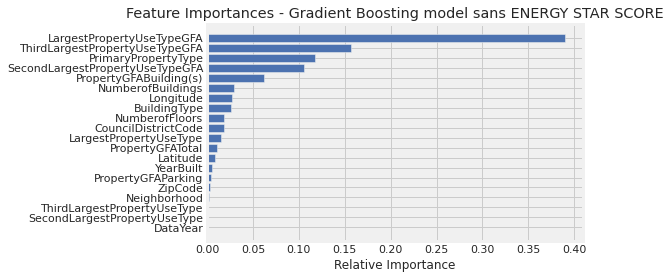

In [34]:
importances = grid_boost_STAR.best_estimator_['model_boost'].feature_importances_
indices = np.argsort(importances)
liste_variables = list(X_STAR.columns)

# style du graphique 
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.figure(1)
plt.title('Feature Importances - Gradient Boosting model sans ENERGY STAR SCORE')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [liste_variables[i] for i in indices])
plt.xlabel('Relative Importance')

#### Evaluation de la cross validation

In [36]:
parameters_opt = {
    'model_boost__n_estimators' : [n_estimators_boost_STAR_opt],
    'model_boost__learning_rate' : [learning_rate_boost_STAR_opt],
    'model_boost__min_samples_split' : [min_samples_split_boost_STAR_opt],
    'model_boost__max_depth' : [max_depth_boost_STAR_opt]
}

In [37]:
grid_boost_STAR_opt = GridSearchCV(estimator = boost_pipe_STAR,
                        param_grid = parameters_opt,
                        scoring='r2',
                        cv=KFold(5, random_state=0, shuffle=True),
                        n_jobs=-1
                          )

In [38]:
grid_boost_STAR_opt.fit(X_STAR_train,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scalar', StandardScaler()),
                                       ('model_boost',
                                        GradientBoostingRegressor(random_state=0))]),
             n_jobs=-1,
             param_grid={'model_boost__learning_rate': [0.06],
                         'model_boost__max_depth': [3],
                         'model_boost__min_samples_split': [15],
                         'model_boost__n_estimators': [1780]},
             scoring='r2')

In [39]:
R2_boost_STAR = round(grid_boost_STAR_opt.best_score_,3)
print(R2_boost_STAR)

0.759


## Choix du meilleur modèle

In [68]:
results = pd.DataFrame({
    'Ridge_regression' : [grid_ridge_STAR.best_estimator_, score_ridge_STAR, R2_ridge_STAR],
    'Random Forest' : [grid_random_STAR.best_estimator_, score_random_STAR, R2_random_STAR],
    'Gradient Boosting' : [grid_boost_STAR.best_estimator_, score_boost_STAR, R2_boost_STAR]
}, index = ['Best estimator', 'Grid search error score', 'R2 score'])

In [69]:
results

,Ridge_regression,Random Forest,Gradient Boosting
Best estimator,"(StandardScaler(), Ridge(alpha=203))","(StandardScaler(), (DecisionTreeRegressor(max_...","(StandardScaler(), ([DecisionTreeRegressor(cri..."
Grid search error score,-200813,-296,-247
R2 score,0.369,0.707,0.759


## Prédiction

### Baseline

In [86]:
#Définition des étapes du pipeline

steps = [
    ('scalar', StandardScaler()),  #Standardisation des données d'entrée pour gommer les différences d'échelles
    ('dummy_regr', DummyRegressor(strategy="mean"))    #Application du modèle
]
dummy_regr_pipe = Pipeline(steps) #Création du pipeline

In [87]:
dummy_regr_pipe.fit(X_STAR_train, y_train)

Pipeline(steps=[('scalar', StandardScaler()), ('dummy_regr', DummyRegressor())])

In [90]:
y_pred_dummy = dummy_regr_pipe.predict(X_STAR_test)

In [91]:
print('RMSE_dummy : ', np.sqrt(mean_squared_error(y_test,y_pred_dummy)))
print('R2_Score_dummy : ', r2_score(y_test,y_pred_dummy))

RMSE_dummy :  913.7825121742885
R2_Score_dummy :  -0.0003238239700298351


### Meilleur modèle

In [70]:
#Prédictions à partir des données tests

y_pred_boost_STAR = grid_boost_STAR.best_estimator_.predict(X_STAR_test)

RMSE_grid :  547.0149351100725
R2_Score_grid :  0.6415296040657681


/home/noura/anaconda3/envs/IMLP3-env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotalGHGEmissions', ylabel='Density'>

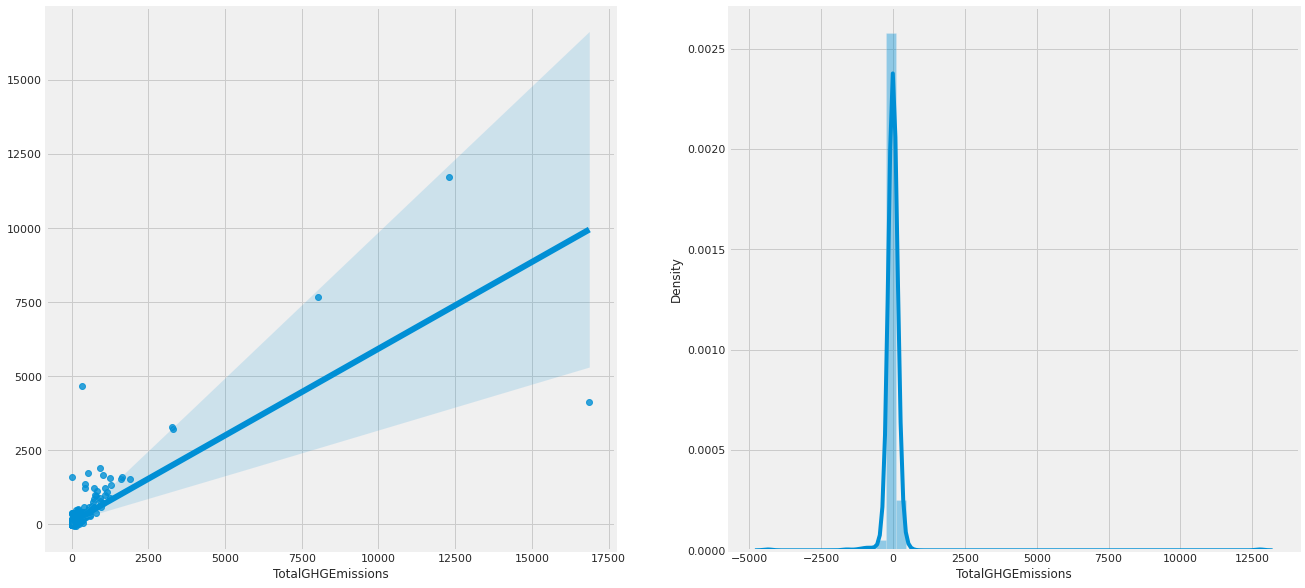

In [71]:
#Evaluation de la prédiction par gradient Boosting

print('RMSE_grid : ', np.sqrt(mean_squared_error(y_test,y_pred_boost_STAR)))
print('R2_Score_grid : ', r2_score(y_test,y_pred_boost_STAR))
f, axes = plt.subplots(1,2,figsize=(20,10))
sns.regplot(x = y_test, y = y_pred_boost_STAR,ax = axes[0])
sns.distplot((y_test-y_pred_boost_STAR),ax = axes[1])